In [1]:
import pandas as pd # packages for reading in data
import numpy as np
import matplotlib.pyplot as plt  # packages for displaying data
from matplotlib.patches import Rectangle
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #packages for statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


sns.set_style("darkgrid") # setting style

In [2]:
df = pd.read_csv("../data/chennai_complete.csv",index_col='date',parse_dates=True, # setting the index to datetime
                 usecols=['date','chembarambakkam_water','chembarambakkam_rain']) # selecting columns

In [6]:
df_m= df.resample("m").mean()

In [10]:
df_m["time"] = range(len(df_m))

In [11]:
interpret_dftest((df_m["chembarambakkam_water"]))

Test Statistic   -3.983308
p-value           0.001500
dtype: float64

In [12]:
adfuller(df_m["chembarambakkam_water"])

(-3.9833081000530304,
 0.0015004816743128208,
 2,
 189,
 {'1%': -3.4654311561944873,
  '5%': -2.8769570530458792,
  '10%': -2.574988319755886},
 2534.8271277324893)

ARIMA models are a subset of linear regression models that attempt to use the past observations of the target variable to forecast its future values.

What the second equation is saying is that the future change in Y is a linear function of the past changes in Y. Why bother with differencing? The reason is that differences are generally much more stationary than the raw undifferenced values. When we do time series modeling, we like our Y variables to be mean variance stationary. This means that the main statistical properties of a model do not vary depending on when the sample was taken. Models built on stationary data are generally more robust.


In [13]:
X = df_m.drop(columns=["chembarambakkam_water","chembarambakkam_rain"])

#X = sm.add_constant(X) # its nessary to add a constant for stats models

y = df_m["chembarambakkam_water"]

# we are not shuffling as this is a time-series and the order matters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .299, shuffle = False)

In [30]:
fitted_arima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 25,
    max_q = 25,
    stationary = True, # being explicit our original dataset is not stationary
    seasonal= True, # ignoring seasonality (for this lesson...)
    solver='lbfgs', # might change, depending on data
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2211.823, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1962.327, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2072.025, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2382.567, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1928.318, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1928.582, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1928.525, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1930.182, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1930.427, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1936.653, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.454 seconds


In [28]:
fitted_arima.order

(2, 0, 0)

In [65]:
X = df_m.drop(columns=["chembarambakkam_water"])

#X = sm.add_constant(X) # its nessary to add a constant for stats models

y = df_m["chembarambakkam_water"]

# we are not shuffling as this is a time-series and the order matters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .299, shuffle = False)

In [66]:
# using `auto_arima`
auto_arima_result = auto_arima(
    y_train, # target data
    exogenous = X_train, # INCLUDING EXOGENOUS VARIABLES
    start_p = 0,
    start_q = 0,
    max_p = 2,
    max_q = 2,
    d = 1, # we know how much to difference, so don't need to waste time searching for this
    stationary = True, # being explicit our original dataset is not stationary
    seasonal=False, # ignoring seasonality (for this lesson...)
    solver='lbfgs', # might change, depending on data
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2212.854, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1965.153, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2074.152, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2255.941, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1931.730, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1934.549, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1933.389, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.267 seconds


In [67]:
water_arima = ARIMA(endog = y_train, exog = X_train, order = (2,0,0)) # freq optional

# fit
fitted_water_arima = water_arima.fit()

In [68]:
water_test_preds  = fitted_water_arima.predict(start = y_test.index[0], # using dates
                                           end = y_test.index[-1], # using dates
                                           exog = X_test,
                                           typ = "levels",
                                           dynamic = False) # actual in-sample because traind on full dataset

In [69]:
r2_score(y_test, water_test_preds)

-1.0424532807095663

Similarly to the AR part, we are doing something with historical values here, hence all the lags. But what is this E? E is commonly called error in most explanations of MA models, and it represents the random residual deviations between the model and the target variable (if you’re asking how it’s possible that we can have errors before we’ve even fit the model, hold that thought for just a second).
The full equation of a basic regression model is:

 E represents the difference between the exact answer and the approximately correct answer delivered by our model.

 MLE (Maximum Likelihood Estimation) 

p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

This model has an AR number of auto regressin lags 
of 2 

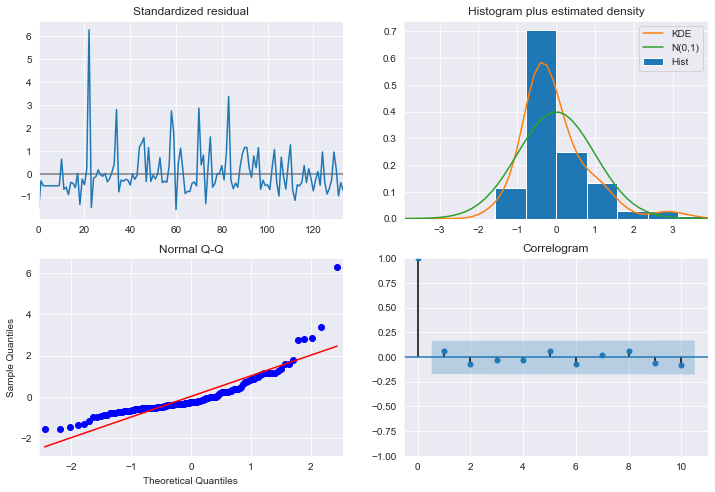

In [22]:
fitted_arima.plot_diagnostics(figsize = (12, 8));

In [16]:
fitted_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -960.159
Date:                Tue, 22 Sep 2020   AIC                           1928.318
Time:                        20:07:36   BIC                           1939.909
Sample:                             0   HQIC                          1933.028
                                - 134                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    162.9731     70.778      2.303      0.021      24.251     301.695
ar.L1          1.3733      0.072     19.051      0.000       1.232       1.515
ar.L2         -0.4880      0.077     -6.372      0.000      -0.638      -0.338
sigma2      9.623e+04   7912.270     12.162      0.000    8.07e+04    1.12e+05
===================================================================================
Ljung-Box (Q):                       58.03   Jarque-Bera (JB):               867.33
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             2.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
order = (2,0,0) # the order I want to use

# instantiate
water_arima = ARIMA(y_train, order = order) 

# fit
water_arima_fitted = water_arima.fit() # stats model returns fitted model

In [42]:
train_preds = water_arima_fitted.predict(start = 0, end = None, dynamic = False, typ = "levels")
train_preds.head()

date
2004-01-31    1421.001563
2004-02-29     109.523107
2004-03-31     162.971164
2004-04-30     162.971164
2004-05-31     162.971164
Freq: M, dtype: float64

In [43]:
# getting train predictions using indexing
test_start = len(y_train) # start after training set, hence + 1
test_end   = len(y_train) + len(y_test) - 1 # include full test set
test_preds = water_arima_fitted.predict(start = test_start, end = test_end, dynamic = False, typ = "levels")
test_preds.head()

2015-03-31     657.057852
2015-04-30     728.178376
2015-05-31     842.343882
2015-06-30     964.422284
2015-07-31    1076.361366
Freq: M, dtype: float64

In [71]:
r2_score(y_train[train_preds.index], train_preds)

0.8691373774996783

In [70]:
r2_score(y_test[test_preds.index], test_preds)

-0.38778407482371136

In [ ]:
air_test_preds  = fitted_air_arima.predict(start = y_test.index[0], # using dates
                                           end = y_test.index[-1], # using dates
                                           exog = X_test,
                                           typ = "levels",
                                           dynamic = False) # actual in-sample because traind on full dataset

In [19]:
water_arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                               
=================================================================================
Dep. Variable:     chembarambakkam_water   No. Observations:                  134
Model:                        ARMA(2, 0)   Log Likelihood                -960.159
Method:                          css-mle   S.D. of innovations            310.217
Date:                   Tue, 22 Sep 2020   AIC                           1928.318
Time:                           20:22:57   BIC                           1939.909
Sample:                       01-31-2004   HQIC                          1933.028
                            - 02-28-2015                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1421.0016    229.041      6.204      0.000     972.090    1869.913
ar.L1.chembarambakkam_water     1.3733      0.075     18.361      0.000       1.227       1.520
ar.L2.chembarambakkam_water    -0.4880      0.076     -6.461      0.000      -0.636      -0.340
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4071           -0.2633j            1.4315           -0.0294
AR.2            1.4071           +0.2633j            1.4315            0.0294
-----------------------------------------------------------------------------
"""

In [23]:
num_steps = len(y_test)
forecast, std_error, conf_int = water_arima_fitted.forecast(steps = num_steps)

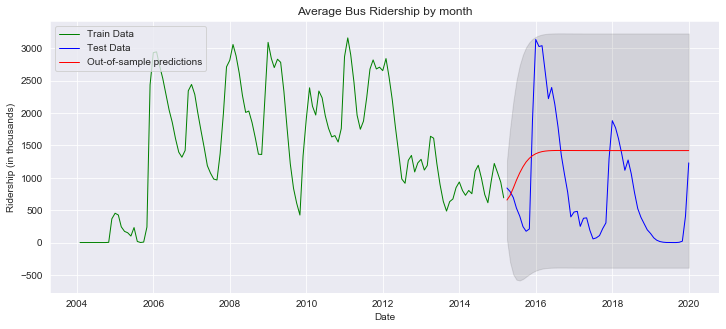

In [24]:
lower_conf_int = conf_int[:,0]
upper_conf_int = conf_int[:,1]

plt.figure(figsize=(12,5))
plt.title("Average Bus Ridership by month")

# train data
plt.plot(y_train.index, y_train, lw=1, color='green', ls='solid',label='Train Data')

# test data
plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')

# forecast data
plt.plot(y_test.index, forecast, lw=1, color='red', ls="solid",  label='Out-of-sample predictions')
plt.xlabel("Date")
plt.ylabel("Ridership (in thousands)")

# conf int
plt.fill_between(y_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1);
plt.legend(loc = "upper left");

In [25]:
r2_score(y_train[train_preds.index], train_preds)

NameError: name 'train_preds' is not defined

In [ ]:
b